In [1]:
# to check in which environment we are working
import sys
print(sys.executable)

e:\Projects\.venv\Scripts\python.exe


In [4]:
import pandas as pd
import mysql.connector
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# # Step 1: Load Data from MySQL
def load_data_from_mysql():
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password='parulantil_2',
        database='call_center',
    )

    query = """
    SELECT call_id, agent, call_date, call_time, topic, answered, resolved, 
           speed_of_answer_sec, avg_talk_duration_sec, satisfaction_rating
    FROM call_data;
    """
    data = pd.read_sql(query, connection)
    connection.close()
    return data

# Load the dataset
data = load_data_from_mysql()
data

,call_id,agent,call_date,call_time,topic,answered,resolved,speed_of_answer_sec,avg_talk_duration_sec,satisfaction_rating
0,ID0001,Diane,2021-01-01,0 days 09:12:58,Contract related,Y,Y,109.0,0 days 00:02:23,3.0\r
1,ID0002,Becky,2021-01-01,0 days 09:12:58,Technical Support,Y,N,70.0,0 days 00:04:02,3.0\r
2,ID0003,Stewart,2021-01-01,0 days 09:47:31,Contract related,Y,Y,10.0,0 days 00:02:11,3.0\r
3,ID0004,Greg,2021-01-01,0 days 09:47:31,Contract related,Y,Y,53.0,0 days 00:00:37,2.0\r
4,ID0005,Becky,2021-01-01,0 days 10:00:29,Payment related,Y,Y,95.0,0 days 00:01:00,3.0\r
...,...,...,...,...,...,...,...,...,...,...
4995,ID4996,Jim,2021-03-31,0 days 16:37:55,Payment related,Y,Y,22.0,0 days 00:05:40,1.0\r
4996,ID4997,Diane,2021-03-31,0 days 16:45:07,Payment related,Y,Y,100.0,0 days 00:03:16,3.0\r
4997,ID4998,Diane,2021-03-31,0 days 16:53:46,Payment related,Y,Y,84.0,0 days 00:01:49,4.0\r
4998,ID4999,Jim,2021-03-31,0 days 17:02:24,Streaming,Y,Y,98.0,0 days 00:00:58,5.0\r


In [5]:
# Step 2: Data Preparation

# Check the structure of the DataFrame
print(data.head())
print(data.columns)

# Strip any whitespace from column names
data.columns = data.columns.str.strip()

# Convert 'Date' column to datetime
data['call_date'] = pd.to_datetime(data['call_date'], format='%Y-%m-%d')  # Use the correct format

# Alternatively, you could try this if the format might vary:
# data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Set 'Date' as the index
data.set_index('call_date', inplace=True)

# Aggregate data: total number of calls per day
total_calls = data.resample('D').size().reset_index(name='total_calls')
print(total_calls.head())  # Display the aggregated calls


  call_id    agent   call_date       call_time              topic answered  \
0  ID0001    Diane  2021-01-01 0 days 09:12:58   Contract related        Y   
1  ID0002    Becky  2021-01-01 0 days 09:12:58  Technical Support        Y   
2  ID0003  Stewart  2021-01-01 0 days 09:47:31   Contract related        Y   
3  ID0004     Greg  2021-01-01 0 days 09:47:31   Contract related        Y   
4  ID0005    Becky  2021-01-01 0 days 10:00:29    Payment related        Y   

  resolved speed_of_answer_sec avg_talk_duration_sec satisfaction_rating  
0        Y               109.0       0 days 00:02:23               3.0\r  
1        N                70.0       0 days 00:04:02               3.0\r  
2        Y                10.0       0 days 00:02:11               3.0\r  
3        Y                53.0       0 days 00:00:37               2.0\r  
4        Y                95.0       0 days 00:01:00               3.0\r  
Index(['call_id', 'agent', 'call_date', 'call_time', 'topic', 'answered',
       

In [6]:
# Step 3: Train/Test Split
train = total_calls[:-2]  # Use all data except the last 14 days for training
test = total_calls[-2:]   # Last 14 days as the test set
test1=total_calls[-14:]

In [ ]:
# Step 6: Check for stationarity using ADF test
def check_stationarity(data):
    adf_test = adfuller(data)
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    if adf_test[1] < 0.05:
        print("The time series is stationary (reject null hypothesis).")
        return True
    else:
        print("The time series is not stationary (fail to reject null hypothesis).")
        return False

In [7]:
# Step 4: SARIMA Model Training
sarima_model = SARIMAX(
    train['total_calls'],
    order=(2, 3, 3),                # Non-seasonal ARIMA (p,d,q)
    seasonal_order=(1, 1, 1, 7),    # Seasonal SARIMA (P,D,Q,m) with weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()


In [8]:
# Step 5: Forecast for the next 14 days
forecast = sarima_result.forecast(steps=14)

In [9]:
# Prepare the forecast DataFrame
forecast_dates = pd.date_range(start=test['call_date'].max() + pd.Timedelta(days=1), periods=14)
forecast_df = pd.DataFrame({
    'call_date': forecast_dates,
    'forecasted_calls': np.round(forecast)
})


In [10]:
# Ensure 'call_date' is the index for both test and forecast data
test = test.set_index('call_date')
forecast_df = forecast_df.set_index('call_date')

In [11]:
# Debug: Print indices to check alignment
print("Test dates:\n", test.index)
print("Forecast dates:\n", forecast_df.index)


Test dates:
 DatetimeIndex(['2021-03-30', '2021-03-31'], dtype='datetime64[ns]', name='call_date', freq=None)
Forecast dates:
 DatetimeIndex(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
               '2021-04-13', '2021-04-14'],
              dtype='datetime64[ns]', name='call_date', freq=None)


In [12]:
# Align test and forecast data
mae = mean_absolute_error(test1['total_calls'], forecast_df['forecasted_calls'])
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 7.785714285714286


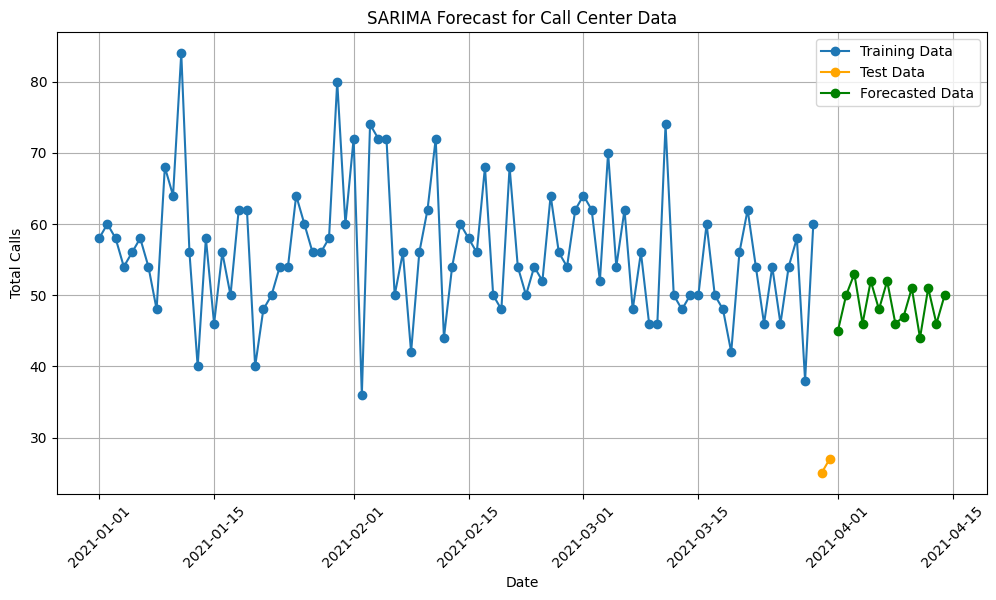

            forecasted_calls
call_date                   
2021-04-01              45.0
2021-04-02              50.0
2021-04-03              53.0
2021-04-04              46.0
2021-04-05              52.0
2021-04-06              48.0
2021-04-07              52.0
2021-04-08              46.0
2021-04-09              47.0
2021-04-10              51.0
2021-04-11              44.0
2021-04-12              51.0
2021-04-13              46.0
2021-04-14              50.0


In [13]:
# Step 6: Visualization of the Results
plt.figure(figsize=(12, 6))

  # Plot the training data
plt.plot(train['call_date'], train['total_calls'], label='Training Data', marker='o')

    # Plot the test data
plt.plot(test.index, test['total_calls'], label='Test Data', marker='o', color='orange')

    # Plot the forecasted data
plt.plot(forecast_df.index, forecast_df['forecasted_calls'], label='Forecasted Data', marker='o', color='green')

plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.title('SARIMA Forecast for Call Center Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
print(forecast_df)
